<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-NEB-end-structures" data-toc-modified-id="Prepare-NEB-end-structures-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare NEB end structures</a></span><ul class="toc-item"><li><span><a href="#Download-from-Materials-Project-and-create-supercell" data-toc-modified-id="Download-from-Materials-Project-and-create-supercell-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download from Materials Project and create supercell</a></span></li><li><span><a href="#Relax-supercells-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet" data-toc-modified-id="Relax-supercells-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Relax supercells with M3GNet-DIRECT, M3GNet-MS, and CHGNet</a></span></li><li><span><a href="#Create-and-relax-NEB-end-structures----b-and-c-directions" data-toc-modified-id="Create-and-relax-NEB-end-structures----b-and-c-directions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create and relax NEB end structures -- b and c directions</a></span></li></ul></li><li><span><a href="#NEB-calculations-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet" data-toc-modified-id="NEB-calculations-with-M3GNet-DIRECT,-M3GNet-MS,-and-CHGNet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NEB calculations with M3GNet-DIRECT, M3GNet-MS, and CHGNet</a></span><ul class="toc-item"><li><span><a href="#generate-NEB-images-from-end-structures-and-conduct-NEB" data-toc-modified-id="generate-NEB-images-from-end-structures-and-conduct-NEB-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>generate NEB images from end structures and conduct NEB</a></span></li><li><span><a href="#analyze-and-plot-NEB-results" data-toc-modified-id="analyze-and-plot-NEB-results-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>analyze and plot NEB results</a></span></li><li><span><a href="#Store-NEB-images-in-one-cif-file-for-visualization" data-toc-modified-id="Store-NEB-images-in-one-cif-file-for-visualization-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Store NEB images in one cif file for visualization</a></span></li><li><span><a href="#Visualize-NEB-path-(snapshots-of-VESTA-visualization-of-path_final.cif)" data-toc-modified-id="Visualize-NEB-path-(snapshots-of-VESTA-visualization-of-path_final.cif)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Visualize NEB path (snapshots of VESTA visualization of path_final.cif)</a></span></li></ul></li></ul></div>


DFT barrier heights: path b = 0.27 eV and path c = 2.5 eV. (see table 1 in https://doi.org/10.1039/C5TA05062F)


In [1]:
from __future__ import annotations

from ase.neb import NEBTools
from pymatgen.ext.matproj import MPRester

from matcalc import NEBCalc, PESCalculator, RelaxCalc

mpr = MPRester('')

# Prepare NEB end structures


## Download from Materials Project and create supercell


In [2]:
s_LFPO = mpr.get_structure_by_material_id("mp-19017")
s_LFPO.make_supercell([1, 2, 2], in_place=True)
s_LFPO.to("NEB_data/LiFePO4_supercell.cif", "cif")
s_LFPO.lattice.abc, s_LFPO.formula

((10.23619605, 11.941510200000154, 9.309834380000202), 'Li16 Fe16 P16 O64')

## Relax supercells with M3GNet-DIRECT, M3GNet-MS, and CHGNet


In [3]:
models = {
    "M3GNet-DIRECT": PESCalculator.load_universal("M3GNet-MP-2021.2.8-DIRECT-PES"),
}

/global/cfs/cdirs/matgen/zihanyu/repos/matgl/src/matgl/apps/pes.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.element_refs = AtomRef(property_offset=torch.tensor(element_refs, dtype=matgl.float_th))
/global/cfs/cdirs/matgen/zihanyu/repos/matgl/src/matgl/apps/pes.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("data_mean", torch.tensor(data_mean, dtype=matgl.float_th))
/global/cfs/cdirs/matgen/zihanyu/repos/matgl/src/matgl/apps/pes.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buff

In [4]:
%%time
results = {}
for model_name, model in models.items():
    relaxer = RelaxCalc(model, optimizer="BFGS", relax_cell=True, fmax=0.02)
    supercell_LFPO_relaxed = relaxer.calc(s_LFPO)["final_structure"]
    results[model_name] = {"supercell_LFPO": supercell_LFPO_relaxed}

CPU times: user 36min 24s, sys: 4min 42s, total: 41min 7s
Wall time: 40.1 s


## Create and relax NEB end structures -- b and c directions


In [5]:
%%time
for model_name, model in models.items():
    relaxer = RelaxCalc(model, optimizer="BFGS", relax_cell=False, fmax=0.02)
    supercell_LFPO_relaxed = results[model_name]["supercell_LFPO"]

    # NEB path along b and c directions have the same starting image.
    s_LFPO_end_b = supercell_LFPO_relaxed.copy()
    s_LFPO_end_b.remove_sites([11])
    s_LFPO_end_b_relaxed = relaxer.calc(s_LFPO_end_b)["final_structure"]
    s_LFPO_end_c = supercell_LFPO_relaxed.copy()
    s_LFPO_end_c.remove_sites([4])
    s_LFPO_end_c_relaxed = relaxer.calc(s_LFPO_end_c)["final_structure"]
    s_LFPO_start_bc = supercell_LFPO_relaxed.copy()
    s_LFPO_start_bc.remove_sites([5])
    s_LFPO_start_bc_relaxed = relaxer.calc(s_LFPO_start_bc)["final_structure"]
    results[model_name].update(
        {
            "supercell_LFPO_end_b": s_LFPO_end_b_relaxed,
            "supercell_LFPO_end_c": s_LFPO_end_c_relaxed,
            "supercell_LFPO_start_bc": s_LFPO_start_bc_relaxed,
        }
    )

CPU times: user 37min 40s, sys: 5min 20s, total: 43min 1s
Wall time: 40.9 s


# NEB calculations with M3GNet-DIRECT, M3GNet-MS, and CHGNet

The universal potentials provide reasonable agreement with each other and with literature.

References:

1. https://pubs.rsc.org/en/content/articlelanding/2011/ee/c1ee01782a
2. https://doi.org/10.1103/PhysRevApplied.7.034007


## generate NEB images from end structures and conduct NEB


In [6]:
%%time
for neb_path in "bc":
    for model_name, model in models.items():
        # Instantiate the NEBCalc object with the desired parameters
        neb_calc = NEBCalc(
            calculator=model,
            optimizer="BFGS",  # Specify the optimizer if different from default
            traj_folder=f"NEB_data/traj_{neb_path}_{model_name}/",
            climb=True,
            fmax=0.05,
            max_steps=1000,  # Specify max_steps if different from default
            get_mep = True,
        )

        results_dict = neb_calc.calc_images(
            start_struct=results[model_name]["supercell_LFPO_start_bc"],
            end_struct=results[model_name][f"supercell_LFPO_end_{neb_path}"],
            n_images=7,
            interpolate_lattices=False,
            autosort_tol=0.5
        )

        barrier = results_dict["barrier"]
        results[model_name][f"mep_{neb_path}"] = results_dict
        results[model_name][f"NEB_{neb_path}"] = neb_calc.neb
        print(f"Barrier along {neb_path} by {model_name}: {barrier} eV.")

/global/cfs/cdirs/matgen/zihanyu/repos/matcalc/src/matcalc/_neb.py:129: FutureWarning: Please import NEB from ase.mep, not ase.neb.
  self.neb = NEB(images, climb=self.climb, allow_shared_calculator=True, **self.kwargs)


      Step     Time          Energy          fmax
BFGS:    0 16:59:30     -756.271484        1.813225
BFGS:    1 16:59:40     -756.389221        1.204485
BFGS:    2 16:59:50     -756.550537        0.738891
BFGS:    3 17:00:00     -756.628784        0.545965
BFGS:    4 17:00:11     -756.659668        0.468723
BFGS:    5 17:00:21     -756.668823        0.463555
BFGS:    6 17:00:31     -756.680542        0.449208
BFGS:    7 17:00:41     -756.698364        0.431072
BFGS:    8 17:00:52     -756.719360        0.316509
BFGS:    9 17:01:01     -756.732788        0.302904
BFGS:   10 17:01:11     -756.739197        0.311044
BFGS:   11 17:01:21     -756.747864        0.311943
BFGS:   12 17:01:30     -756.758545        0.260824
BFGS:   13 17:01:40     -756.772095        0.282939
BFGS:   14 17:01:50     -756.785278        0.267560
BFGS:   15 17:01:59     -756.792969        0.234110
BFGS:   16 17:02:09     -756.797729        0.225239
BFGS:   17 17:02:19     -756.803101        0.180508
BFGS:   18 17:

/global/cfs/cdirs/matgen/zihanyu/repos/matcalc/src/matcalc/_neb.py:141: FutureWarning: Please import NEBTools from ase.mep, not ase.neb.
  neb_tool = NEBTools(self.neb.images)


Barrier along b by M3GNet-DIRECT: 0.1573486328124991 eV.
      Step     Time          Energy          fmax
BFGS:    0 17:06:06     -755.308411        4.674320
BFGS:    1 17:06:16     -755.583130        1.754711
BFGS:    2 17:06:27     -755.708191        1.327193
BFGS:    3 17:06:37     -755.897217        0.831325
BFGS:    4 17:06:46     -755.949951        0.620406
BFGS:    5 17:06:57     -755.975037        0.663379
BFGS:    6 17:07:07     -755.987915        0.544550
BFGS:    7 17:07:17     -756.006226        0.422222
BFGS:    8 17:07:27     -756.031494        0.284991
BFGS:    9 17:07:36     -756.050659        0.260647
BFGS:   10 17:07:46     -756.059509        0.311953
BFGS:   11 17:07:55     -756.064026        0.283956
BFGS:   12 17:08:05     -756.067139        0.238249
BFGS:   13 17:08:15     -756.071899        0.184460
BFGS:   14 17:08:24     -756.077820        0.125588
BFGS:   15 17:08:34     -756.081360        0.132945
BFGS:   16 17:08:44     -756.083618        0.115633
BFGS:   1

## analyze and plot NEB results


Path along b, M3GNet-DIRECT: 


<timed exec>:5: FutureWarning: Please import NEBTools from ase.mep, not ase.neb.


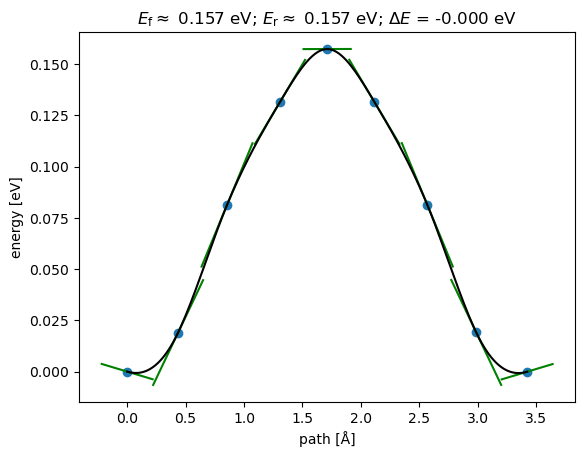

Path along c, M3GNet-DIRECT: 


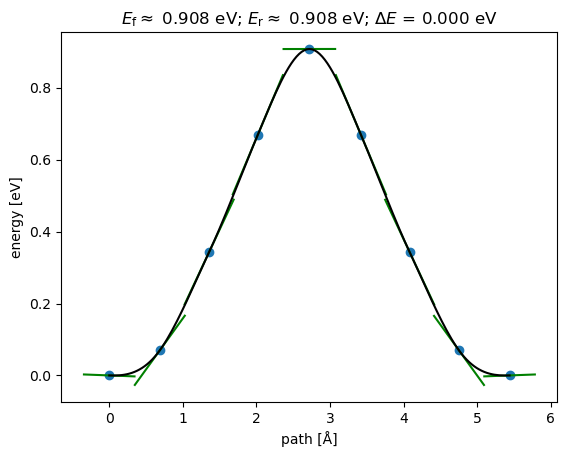

CPU times: user 16min 17s, sys: 1min 50s, total: 18min 7s
Wall time: 18.9 s


In [7]:
%%time
import matplotlib.pyplot as plt

for neb_path in "bc":
    for model_name, model in models.items():
        NEB_tool = NEBTools(results[model_name][f"NEB_{neb_path}"].images)
        print(f"Path along {neb_path}, {model_name}: ")
        fig = NEB_tool.plot_band()
        plt.show()

## Store NEB images in one cif file for visualization


In [8]:
from itertools import chain

from pymatgen.core import PeriodicSite, Structure
from pymatgen.io.ase import AseAtomsAdaptor


def generate_path_cif_from_images(images: list, filename: str) -> None:
    """Generate a cif file from a list of image atoms."""
    image_structs = [AseAtomsAdaptor.get_structure(image) for image in images]
    sites = set()
    lattice = image_structs[0].lattice
    sites.update(
        PeriodicSite(site.species, site.frac_coords, lattice) for site in chain(*(struct for struct in image_structs))
    )
    neb_path = Structure.from_sites(sorted(sites))
    neb_path.to(filename, "cif")

In [9]:
%%time
for neb_path in "bc":
    for model_name, model in models.items():
        NEB_tool = NEBTools(results[model_name][f"NEB_{neb_path}"].images)
        generate_path_cif_from_images(NEB_tool.images, f"NEB_data/traj_{neb_path}_{model_name}/path_final.cif")

<timed exec>:3: FutureWarning: Please import NEBTools from ase.mep, not ase.neb.


CPU times: user 12.5 s, sys: 577 ms, total: 13.1 s
Wall time: 12.5 s


## Visualize NEB path (snapshots of VESTA visualization of path_final.cif)


In [10]:
from IPython.display import Image

Final path b by M3GNet-DIRECT:


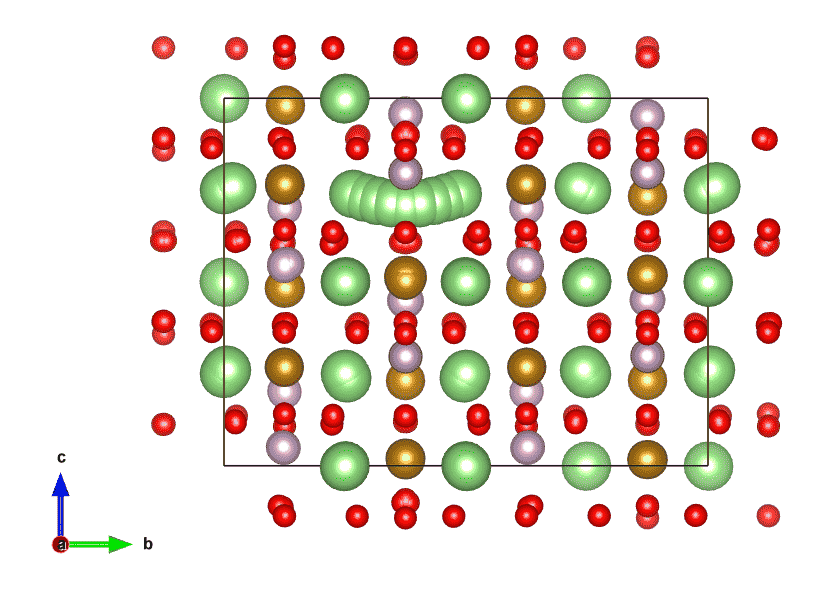

In [11]:
print("Final path b by M3GNet-DIRECT:")
Image("NEB_data/M3GNet-DIRECT-path-b.png")

Final path c by M3GNet-DIRECT:


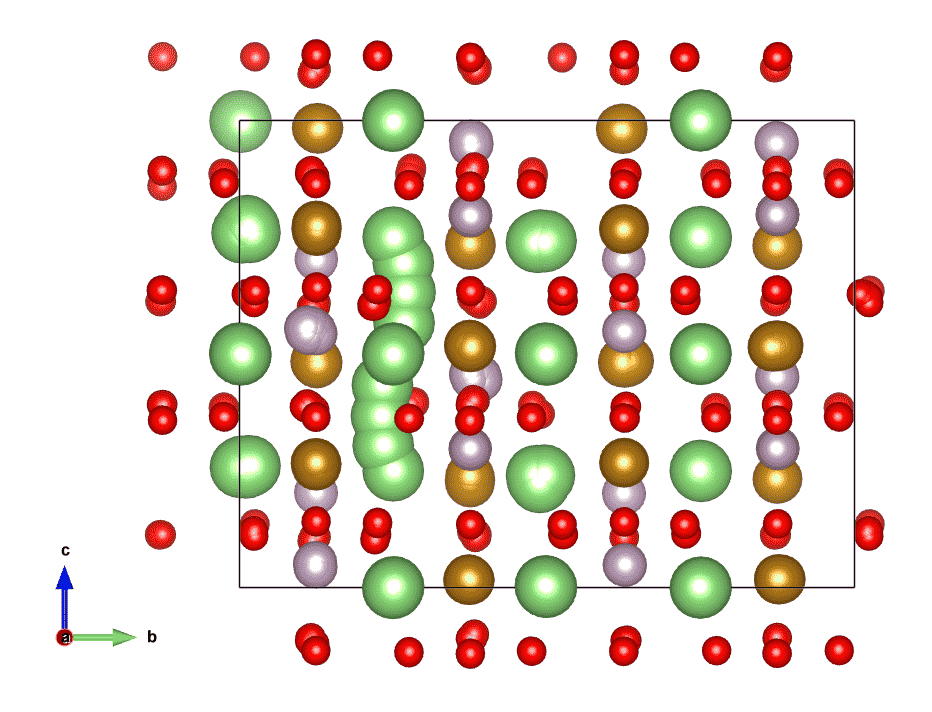

In [12]:
print("Final path c by M3GNet-DIRECT:")
Image("NEB_data/M3GNet-DIRECT-path-c.png")